## Import dependencies and data

In [1]:
import os
import pandas as pd
import tensorflow as tf

In [2]:
gpus=tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

### Visualize data

In [3]:
df=pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
len(df)

50000

In [5]:
print(len(df.iloc[0]['review']))
print(len(df.iloc[12]['review']))
print(len(df.iloc[128]['review']))

1761
2227
1048


In [6]:
df.iloc[0]['review']

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [7]:
df.iloc[:5]['sentiment']

0    positive
1    positive
2    positive
3    negative
4    positive
Name: sentiment, dtype: object

In [8]:
from tensorflow.keras.layers import TextVectorization

In [9]:
reviews=df['review']
sentiment=df['sentiment']

In [11]:
sentiment=sentiment.apply(lambda x: 1 if x=='positive' else 0)

In [12]:
class_label=['Negative','Positive']

In [13]:
sentiment.values.shape

(50000,)

In [14]:
Max_features=40000

In [15]:
vectorizer=TextVectorization(max_tokens=Max_features,output_sequence_length=4000,output_mode='int')

In [16]:
vectorizer.adapt(reviews.values)

In [17]:
vectorizer('I didn\'t liked the movie')[:6]

<tf.Tensor: shape=(6,), dtype=int64, numpy=array([ 10, 150, 412,   2,  18,   0], dtype=int64)>

In [18]:
vectorized_text=vectorizer(reviews.values)

In [19]:
vectorized_text.shape

TensorShape([50000, 4000])

In [20]:
vectorized_text[0]

<tf.Tensor: shape=(4000,), dtype=int64, numpy=array([29,  5,  2, ...,  0,  0,  0], dtype=int64)>

## Creating training pipeline

In [21]:
# MCSHBAP pipeline
dataset=tf.data.Dataset.from_tensor_slices((vectorized_text,sentiment))
dataset=dataset.cache()
dataset=dataset.shuffle(50000)
dataset=dataset.batch(64)
dataset=dataset.prefetch(32)

In [22]:
reviews,sentiments=dataset.as_numpy_iterator().next()
reviews,sentiments

(array([[   44,  1620,    86, ...,     0,     0,     0],
        [ 2918, 12031,     3, ...,     0,     0,     0],
        [25542, 10346,    17, ...,     0,     0,     0],
        ...,
        [    1,     0,     0, ...,     0,     0,     0],
        [ 1446, 21228,    13, ...,     0,     0,     0],
        [   48,    14,     4, ...,     0,     0,     0]], dtype=int64),
 array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
        1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0],
       dtype=int64))

In [23]:
reviews.shape,sentiments.shape

((64, 4000), (64,))

In [24]:
train_size=int(len(dataset)*.7)
val_size=int(len(dataset)*.2)
test_size=int(len(dataset)*.1)+1
print(len(dataset))
print(train_size,val_size,test_size,(train_size+test_size+val_size))

782
547 156 79 782


In [25]:
train=dataset.take(train_size)
val=dataset.skip(train_size).take(val_size)
test=dataset.skip(train_size+val_size).take(test_size)

In [26]:
train_generator=train.as_numpy_iterator()

In [27]:
batch=train_generator.next()
batch[0].shape,batch[1].shape

((64, 4000), (64,))

In [28]:
batch

(array([[  10,  194,  146, ...,    0,    0,    0],
        [   1, 3083,   16, ...,    0,    0,    0],
        [  10,  417,    2, ...,    0,    0,    0],
        ...,
        [ 166,  852,  538, ...,    0,    0,    0],
        [  11,    7,    2, ...,    0,    0,    0],
        [  43,  925,  229, ...,    0,    0,    0]], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0],
       dtype=int64))

## building model

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Bidirectional,Embedding,Dropout

In [30]:
model=Sequential()

model.add(Embedding(Max_features+1,32,input_length=4000))

model.add(Bidirectional(LSTM(64,activation='tanh')))

model.add(Dense(256,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(128,activation='tanh'))

model.add(Dense(1,activation='sigmoid'))

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4000, 32)          1280032   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49664     
 l)                                                              
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                        

In [32]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam())

In [41]:
model.load_weights('models\\imdb_model.h5')

In [ ]:
history=model.fit(train,epochs=16,validation_data=val)
model_history=history.history

### Plot model loss

In [34]:
import matplotlib.pyplot as plt

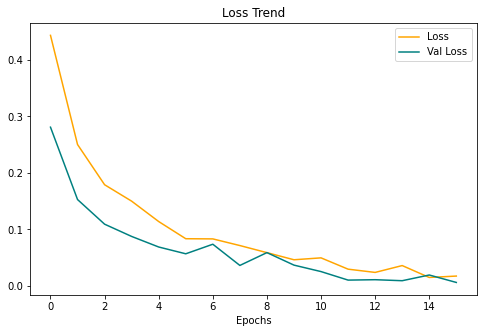

In [36]:
plt.figure(figsize=(8,5))
plt.plot(model_history['loss'],color='orange',label='Loss')
plt.plot(model_history['val_loss'],color='teal',label='Val Loss')
plt.title('Loss Trend')
plt.legend()
plt.xlabel('Epochs')
plt.show()

## Evaluate the model

In [37]:
from tensorflow.keras.metrics import Precision,Recall,BinaryAccuracy

In [42]:
pre=Precision()
re=Recall()
acc=BinaryAccuracy()

In [43]:
for batch in test.as_numpy_iterator():
    reviews,sentiments=batch
    preds=model.predict(reviews,verbose=0)
    sentiments=sentiments.flatten()
    preds=preds.flatten()

    pre.update_state(sentiments,preds)
    re.update_state(sentiments,preds)
    acc.update_state(sentiments,preds)

In [44]:
print(f'Precision: {pre.result()}')
print(f'Recall: {re.result()}')
print(f'Binary Accuracy: {acc.result()}')

Precision: 0.7335473299026489
Recall: 0.7236738204956055
Binary Accuracy: 0.7280351519584656


In [ ]:
tf.keras.models.save_model(model,os.path.join('models','imdb_model.h5'))

## Making Predictions

In [49]:
import numpy as np

In [95]:
def get_sentiment(pred):
    stat=None
    conf=None
    for i in pred:
        if i.item()>=.5:
            stat=1
            conf=i.item()
        else:
            stat=0
            conf=1-i.item()
    print(f'{class_label[stat]} with a confidence of {conf*100:.4}%')

In [96]:
text=vectorizer("Ive seen it and to be honest, it is straight GARBAGE I've heard of this movie, expecting it to be good but when watching I couldn't help but feel this was the same as almost every other movie")
get_sentiment(model.predict(np.expand_dims(text,0),verbose=0))

Negative with a confidence of 92.97%


In [97]:
text=vectorizer("Impeccable animation, art, the overall graphics; Amazing music and ambience selection. Very well put together. The only thing that is, in my opinion, takes the movie from a 5 to a 4 is sometimes, you can get lost/confused at certain parts of the film (Doesn't happen often). Overall, I'm not saying it's a bad film by any means, it's got amazing visuals, great voice acting and at certain parts of the film, I was really immersed. I would recommend it.")
get_sentiment(model.predict(np.expand_dims(text,0),verbose=0))

Positive with a confidence of 99.95%
